In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
from sklearn.model_selection import train_test_split
from datetime import datetime
from tqdm import tqdm
from sklearn.utils import shuffle
import nltk


In [25]:
# %load DNN.py
class DNN():
    
    number = 0
    
    def __init__(self,X_train,y_train,layers,as_placeholders=True,dtypes=[tf.float32,tf.float32],**kwargs):
        self.X_train = X_train
        self.y_train = y_train
        if as_placeholders:
            self.X = tf.placeholder(dtype=dtypes[0],shape=(None,)+X_train.shape[1:])
            self.y = tf.placeholder(dtype=dtypes[1],shape=(None,)+y_train.shape[1:])
        else:
            self.X = X_train
            self.y = y_train
        self.layers = layers
        self.activations = [self.X]
        DNN.number +=1
            
    def forward(self):       
        for i,layer in enumerate(self.layers):
            layer.set_input(self.activations[i])
            self.activations.append(layer.forward())
        return self.activations
    
    def cost(self):
        #return tf.reduce_sum(tf.square(self.activations[-1]-self.y))
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.activations[-1],labels=self.y))
    
    def squared_cost(self):
        return tf.reduce_mean(tf.squared_difference(self.activations[-1], self.y))
    
    def kl_divergence(self,p, q): 
        return tf.reduce_sum(p * tf.log(p/q))
       # return tf.contrib.distributions.kl_divergence(p, q,)
class DenseLayer():
    
    number = 0
    
    def __init__(self,units,activation_function=tf.nn.relu,batch_norm=False,keep_prob=1.0,initialize_weights=None):
        self.units = units
        self.keep_prob = keep_prob
        self.activation_function = activation_function
        self.batch_norm = batch_norm
        self.variable_scope_name = 'Dense-'+str(DenseLayer.number)
        self.initialize_weights = initialize_weights
        DenseLayer.number+=1
        
    def set_input(self,x):
        self.x = x
        if(len(x.shape)==4):
            shape = self.x.get_shape().as_list()        
            dim = np.prod(shape[1:])
            self.x = tf.reshape(tensor=self.x,shape=[-1,dim])

        with tf.variable_scope(self.variable_scope_name):  
            self.init_W((self.x.get_shape().as_list()[1],self.units))
            self.init_b(self.units)
            if(self.batch_norm):
                self.epsilon = 1e-3
                self.scale = tf.get_variable('scale', initializer=tf.ones(shape=[self.units]))
                self.beta =  tf.get_variable('beta', initializer=tf.zeros(shape=[self.units]))

        
    def init_W(self,shape):
        #another way to do this with get variable
        #self.w= tf.Variable(tf.multiply(tf.random_normal(shape),0.01),dtype=tf.float32)'
        if self.initialize_weights is None: 
            self.w=tf.get_variable('weight',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        else:
            self.w=tf.get_variable('weight',shape=shape,initializer=tf.constant_initializer(self.initialize_weights))
        tf.summary.histogram('weight',self.w)
    
    def init_b(self,shape):
        #self.b = tf.Variable(tf.fill([shape],0.1),dtype=tf.float32)
        init = tf.constant(0.1,shape=[shape])
        self.b = tf.get_variable('bias', initializer=init)
        tf.summary.histogram('bias',self.b)
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            #batch norm not working properly
            #or maybe it is working properly but it needs bigger batch size. like 64. This makes sense because you make estimates of
            #mean and variance for every z calculation. This means that the bigger the batch size the more accurate the estimate
            if(self.batch_norm):
                self.z = tf.matmul(self.x,self.w)
                self.batch_mean, self.batch_var = tf.nn.moments(self.z,[0])
                self.z  = tf.nn.batch_normalization(self.z,self.batch_mean,self.batch_var,self.beta,self.scale,self.epsilon)
            else:
                self.z = tf.nn.xw_plus_b(self.x,self.w,self.b)
            if self.activation_function == None:
                self.activation = self.z
            else:
                self.activation  = self.activation_function(self.z)
            self.activation = tf.nn.dropout(self.activation,self.keep_prob)
            tf.summary.histogram('activations',self.activation)
            return self.activation
        
class ConvLayer():

    number = 0
    def __init__(self,kernel_size,number_of_kernels,padding='SAME',activation_function=tf.nn.relu,batch_norm = False,keep_prob=1.0):
        self.kernel_size = kernel_size
        self.number_of_kernels = number_of_kernels
        self.padding = padding
        self.activation_function = activation_function
        self.keep_prob = keep_prob
        self.batch_norm = batch_norm
        self.variable_scope_name = 'Conv-'+str(ConvLayer.number)
        ConvLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
            if(isinstance(self.kernel_size,tuple)):
                self.init_Kernel(self.kernel_size+(x.get_shape().as_list()[-1],self.number_of_kernels))
            else:
                self.init_Kernel((self.kernel_size,self.kernel_size,x.get_shape().as_list()[-1],self.number_of_kernels)) 
            self.init_b(self.number_of_kernels)
            if(self.batch_norm):
                self.epsilon = 1e-3
                self.scale = tf.get_variable('scale', initializer=tf.ones(shape=[self.number_of_kernels]))
                self.beta =  tf.get_variable('beta', initializer=tf.zeros(shape=[self.number_of_kernels]))
        
    def init_Kernel(self,shape):
        self.kernel=tf.get_variable('kernel',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('kernel',self.kernel)
        
    def init_b(self,shape):
        self.b = tf.get_variable('bias',shape=[shape],initializer=tf.constant_initializer(0.1))
        tf.summary.histogram('bias',self.b)
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if self.batch_norm:
                
                self.z = tf.nn.conv2d(self.x , self.kernel, [1, 1, 1, 1], padding=self.padding)
                self.batch_mean, self.batch_var = tf.nn.moments(self.z,[0,1,2])
                self.z  = tf.nn.batch_normalization(self.z,self.batch_mean,self.batch_var,self.beta,self.scale,self.epsilon)
                
            else:
                self.z = tf.nn.conv2d(self.x , self.kernel, [1, 1, 1, 1], padding=self.padding)
                self.z = tf.nn.bias_add(self.z, self.b)  
                    
            if self.activation_function == None:
                self.activation = self.z
            else:
                self.activation  = self.activation_function(self.z)
            #dropout
            self.activation = tf.nn.dropout(self.activation,self.keep_prob)
            tf.summary.histogram('activations',self.activation)
        return self.activation
        
class PoolingLayer():
    
    number = 0
    
    def __init__(self,kernel_size,stride,padding='SAME',pooling='MAX'):
        self.kernel_size = kernel_size
        self.stride = stride
        self.pooling = pooling
        self.padding = padding
        self.variable_scope_name = 'Pool-'+str(PoolingLayer.number)
        PoolingLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if(isinstance(self.kernel_size,tuple)):
                size = list(self.kernel_size)
            else:
                size = [self.kernel_size,self.kernel_size]   
            if (self.pooling == 'MAX'):
                self.activation = tf.nn.max_pool(self.x,[1]+size+[1],[1,self.stride,self.stride,1],padding=self.padding)
            elif (self.pooling == 'AVG'):
                self.activation = tf.nn.avg_pool(self.x,[1]+size+[1],[1,self.stride,self.stride,1],padding=self.padding)
        return self.activation
    
class EmbeddingLayer():
    
    number = 0
    
    def __init__(self,vocabulary_size,embedding_diamension,pretrained_word2vec=True,as_sequences=None):
        self.embedding_diamension = embedding_diamension
        self.vocabulary_size = vocabulary_size
        self.pretrained_word2vec = pretrained_word2vec
        self.variable_scope_name = 'Embedding-'+str(PoolingLayer.number)
        self.init_Embeddings((self.vocabulary_size,self.embedding_diamension))
        self.as_sequences = as_sequences
        EmbeddingLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
            if self.as_sequences:
                self.sequence_length = x.shape[1]
        
    def init_Embeddings(self,shape):
        with tf.variable_scope(self.variable_scope_name):  
            if(self.pretrained_word2vec):             
                self.W = tf.Variable(tf.constant(0.0, shape=[self.vocabulary_size, self.embedding_diamension]),trainable=True, name="embedding_weights")
                self.embedding_placeholder = tf.placeholder(tf.float32, [self.vocabulary_size, self.embedding_diamension])
                self.embedding_init = self.W.assign(self.embedding_placeholder)
            else:
                self.W = tf.get_variable("embedding_weights", shape=[self.vocabulary_size, self.embedding_diamension],initializer=tf.contrib.layers.xavier_initializer())
    def forward(self):
        # TODO: implement as sequences to provide data for lstm
        if self.x == None:
            print('no input defined')
        else:
            #this is called activation to follow the pattern of other layers
            self.activation = tf.nn.embedding_lookup(self.W, self.x)
            if self.as_sequences == 'static':
                self.activation = tf.transpose(self.activation, [1,0,2])
                self.activation = tf.reshape(self.activation , [-1,self.embedding_diamension])
                self.activation  = tf.split(self.activation ,self.sequence_length,0)
            elif self.as_sequences == 'dynamic':
                pass
            else:
                self.activation = tf.expand_dims(self.activation, -1)        #need 4 diamensions to apply convolution
            return self.activation
class RnnLayer():
    number = 0
    def __init__(self,units,activation_function = None,cell_type = 'LSTM',keep_prob=1.0,rnn_type='static'):
        self.units = units
        self.activation_function = activation_function
        self.keep_prob = keep_prob
        self.cell_type = cell_type
        self.rnn_type = rnn_type
        self.variable_scope_name = 'Rnn-'+str(RnnLayer.number)
        RnnLayer.number+=1
        
    def set_input(self,x):
        with tf.variable_scope(self.variable_scope_name):         
            self.x = x
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            if self.cell_type == 'LSTM':
                cell = tf.nn.rnn_cell.LSTMCell(self.units,activation=self.activation_function)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self.keep_prob)
            elif self.cell_type == 'GRU':
                cell = tf.nn.rnn_cell.GRUCell(self.units,activation=self.activation_function)
                cell = tf.nn.rnn_cell.DropoutWrapper(cell=cell, output_keep_prob=self.keep_prob)
                
            #need to fix this
            #self.activation = tf.nn.dynamic_rnn(cell,self.x,sequence_length=self.sequence_length)
            if (self.rnn_type == 'static'):
                self.output, self.states = tf.nn.static_rnn(cell,self.x,dtype=tf.float32)
                self.activation = self.output[-1]
            elif (self.rnn_type == 'dynamic'):
                self.output, self.states = tf.nn.dynamic_rnn(cell,self.x,dtype=tf.float32)
                self.activation = self.output[:,-1,:]
        return self.activation
    

In [3]:
tf.__version__

'1.4.0'

In [77]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('D:/programming/python/datasets/mnist_data', one_hot=True)

X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels
# X_train = np.concatenate((X_train,X_test))
# y_train = np.concatenate((y_train,y_test))
y_train = np.argmax(y_train,axis=1).reshape((-1,1))

Extracting D:/programming/python/datasets/mnist_data\train-images-idx3-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\train-labels-idx1-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\t10k-images-idx3-ubyte.gz
Extracting D:/programming/python/datasets/mnist_data\t10k-labels-idx1-ubyte.gz


In [5]:
class SAE():
    
    def __init__(self,X_train,layer_dimensions):
        self.X_train = X_train
        self.input_dimensions = X_train.shape[1]
        self.layer_dimensions = layer_dimensions
        self.init_layers()
        with tf.variable_scope('encoder'):
            self.encoder = DNN(X_train,X_train,self.encoder_layers)
            self.encoder_activations = self.encoder.forward()
            self.encoder_output = self.encoder_activations[-1]
        with tf.variable_scope('decoder'):
            self.decoder = DNN(self.encoder_output,self.encoder.y,self.decoder_layers,as_placeholders=False)# transfoermed x and previous y which were placeholders
            self.decoder_activations = self.decoder.forward()
    
    def init_layers(self):
        
        self.encoder_layers = []
        self.decoder_layers = []
        for i in self.layer_dimensions[:-1]:
            self.encoder_layers.append(DenseLayer(i))
        self.encoder_layers.append(DenseLayer(self.layer_dimensions[-1],activation_function=None)) ##bottleneck layer
        for i in reversed(self.layer_dimensions[:-1]):
            self.decoder_layers.append(DenseLayer(i))
        self.decoder_layers.append(DenseLayer(self.input_dimensions,activation_function=None)) #output layer no activation
        
    def fit(self,num_epochs,batch_size):

        loss = self.decoder.squared_cost()
        tf.summary.scalar('loss', loss)
        optimizer = tf.train.AdamOptimizer()
        train = optimizer.minimize(loss)

        correct_pred = tf.equal(tf.argmax(self.decoder_activations[-1], 1), tf.argmax(self.encoder.X, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        merged = tf.summary.merge_all()
        
        saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            #write training data to file in order to visualize it with tensorboard
            log_name = datetime.now().strftime("%Y%m%d-%H%M%S")
            #train_writer = tf.summary.FileWriter('summaries/train/logs'+log_name,sess.graph)
            test_writer = tf.summary.FileWriter('summaries/test/logs'+log_name,sess.graph)

            #training 
            for i in tqdm(range(num_epochs)):
                for c,batch in enumerate(range(int(np.ceil(mnist.train.num_examples/batch_size)))):
                    batch = mnist.train.next_batch(batch_size=batch_size)
                    batch_x = batch[0]
                    feed_dict={self.encoder.X : batch_x,self.encoder.y : batch_x}
                    cost,_,acc= sess.run([loss,train,accuracy],feed_dict=feed_dict)

                feed_dict={self.encoder.X : self.X_train,self.encoder.y : self.X_train}
                summary,test_acc,test_cost = sess.run([merged,accuracy,loss],feed_dict=feed_dict)
                test_writer.add_summary(summary, i)  
            feed_dict={self.encoder.X : self.X_train,self.encoder.y : self.X_train}
            self.extract_feature = sess.run(self.encoder_output,feed_dict=feed_dict)
            saver.save(sess, './model/my-test-model')
        
        

In [34]:
class ClusteringLayer():
    
    number = 0 
    
    def __init__(self, n_clusters, alpha=1.0,initialize_weights = None):
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initialize_weights = initialize_weights
        self.variable_scope_name = 'Clustering-'+str(ClusteringLayer.number)
        ClusteringLayer.number+=1
        
    def set_input(self,x):
        
        self.x = x

        with tf.variable_scope(self.variable_scope_name):  
            self.init_Clusters((self.n_clusters,self.x.get_shape().as_list()[1]))
        
    def init_Clusters(self,shape):
        if self.initialize_weights is None: 
            self.clusters=tf.get_variable('weight',shape=shape,initializer=tf.contrib.layers.xavier_initializer())
        else:
            self.clusters=tf.get_variable('weight',shape=shape,initializer=tf.constant_initializer(self.initialize_weights))
        tf.summary.histogram('weight',self.clusters)
        
    def forward(self):
        if self.x == None:
            print('no input defined')
        else:
            q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(self.x, axis=1) - self.clusters), axis=2) / self.alpha))
            q **= (self.alpha + 1.0) / 2.0
            q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1))
            return q
            
        

    

In [35]:
tf.reset_default_graph()
DenseLayer.number = 0
ConvLayer.number = 0
PoolingLayer.number = 0
EmbeddingLayer.number = 0
RnnLayer.number = 0
SAE.number = 0


sae = SAE(X_train,[500, 500, 2000, 10])
sae.fit(50,256)
sae.extract_feature.shape


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:19<00:00, 11.42s/it]


(65000, 10)

In [55]:
#restore the weights i need from the encoder
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./model/my-test-model.meta')##copies the graph
    sess.run(tf.global_variables_initializer())
    graph = tf.get_default_graph()

#check all variables that exist
#     for i in graph.get_collection('variables'):
#         if 'encoder' in  i.name:
#             weights.append(graph.get_tensor_by_name(i.name).eval())
#             print(i.get_variable_scope

    weights=[]
    for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder'):
        if 'weight:0' in  i.name:
            weights.append(graph.get_tensor_by_name(i.name).eval())
            print(i)
#     get_operation = graph.get_tensor_by_name('encoder/activations_3/tag')
#     features = sess.run(get_operation)

<tf.Variable 'encoder/Dense-0/weight:0' shape=(784, 500) dtype=float32_ref>
<tf.Variable 'encoder/Dense-1/weight:0' shape=(500, 500) dtype=float32_ref>
<tf.Variable 'encoder/Dense-2/weight:0' shape=(500, 2000) dtype=float32_ref>
<tf.Variable 'encoder/Dense-3/weight:0' shape=(2000, 10) dtype=float32_ref>


In [ ]:
from sklearn.cluster import KMeans
tf.reset_default_graph()
DenseLayer.number = 0
ConvLayer.number = 0
PoolingLayer.number = 0
EmbeddingLayer.number = 0
RnnLayer.number = 0
SAE.number = 0

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def target_distribution_np(q):
    weight = np.square(q) / np.sum(q,axis=0)
    return np.transpose( np.transpose(weight) /np.sum(weight,axis=1))

def target_distribution(q):
    weight = tf.square(q) / tf.reduce_sum(q,axis=0)
    return tf.transpose( tf.transpose(weight) /tf.reduce_sum(weight,axis=1))

#p = tf.placeholder(dtype=tf.float32,shape=(None,10))

#create encoder with pretrained weights
encoder = DNN(X_train,y_train,[DenseLayer(500,initialize_weights=weights[0]),DenseLayer(500,initialize_weights=weights[1]),\
                               DenseLayer(2000,initialize_weights=weights[2]),DenseLayer(10,initialize_weights=weights[3]),\
                                ],dtypes=[tf.float32,tf.int32])

encoder_output = encoder.forward()[-1]
#get encoder features
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    features = sess.run(encoder_output,feed_dict={encoder.X:X_train,encoder.y:y_train})

#get kmean weights to initialize clustering layer
print('kmeans')
n_clusters=10
km = KMeans(n_clusters, n_init=20)
y_pred = km.fit_predict(features)
kmeans_weights =km.cluster_centers_ 
print(km.cluster_centers_.shape)

clustering = DNN(encoder_output,encoder.y,[ClusteringLayer(10,initialize_weights=kmeans_weights)],as_placeholders=False)
############################################print(clustering.layers[-1].variable_scope_name)
q = clustering.forward()[-1]

p = target_distribution(q)

kld_cost = clustering.kl_divergence(p,q)
optimizer = tf.train.MomentumOptimizer(0.001,0.9)
#optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(kld_cost)

# corrects = tf.equal(tf.argmax(q,axis=1,output_type=tf.int32),encoder.y)
# accuracy = tf.reduce_mean(tf.cast(corrects,tf.float32))


num_epochs = 100
batch_size = 256
tol=1e-3

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    #training 
    y_pred_last = 1
    for i in tqdm(range(num_epochs)):
        for c,batch in enumerate(range(int(np.ceil(mnist.train.num_examples/batch_size)))):
            batch = mnist.train.next_batch(batch_size=batch_size)
            batch_x = batch[0]
            batch_y = batch[1]
            batch_y = np.argmax(batch_y,axis=1).reshape(-1,1)
            #feed_dict={encoder.X : batch_x,encoder.y : batch_y }
#             p_value = target_distribution(q_value)
            #cost,_,=sess.run([kld_cost,train],feed_dict={encoder.X : batch_x,p:p_value,encoder.y : batch_y }) 
            p_value,q_value,cost,_,=sess.run([p,q,kld_cost,train],feed_dict={encoder.X : batch_x}) 
            batch_train_acc_p = cluster_acc(batch_y,np.argmax(p_value,axis=1).reshape(-1,1))
            batch_train_acc = cluster_acc(batch_y,np.argmax(q_value,axis=1).reshape(-1,1))
            if c%40==0:
                print("cost: "+str(cost)+"\taccuracy: "+ str(batch_train_acc)+"\t p accuracy: "+ str(batch_train_acc_p)+" in " + str(i) + 'epoch in ' +str(c) +'batch')
        
#         feed_dict={encoder.X : X_train, encoder.y:y_train}
#         cost,train_acc= sess.run([kld_cost,accuracy],feed_dict=feed_dict)   
#         print("cost: "+cost+"\taccuracy: "+ accuracy+" in " + i + 'epoch')
        # check stop criterion
#         if i > 0 and delta_label < tol:
#             print('delta_label '+ str(delta_label)+ '< tol '+ str(tol))
#             print('Reached tolerance threshold. Stopping training.')
#             break
#         feed_dict={encoder.X : X_train,encoder.y : y_train}
#         test_acc,test_cost = sess.run([accuracy,kld_cost],feed_dict=feed_dict)
        #test_writer.add_summary(summary, i)  


kmeans


In [54]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

print('performing k-means clustering on the extracted features')

n_clusters=10
print(sae.extract_feature.shape)
km = KMeans(n_clusters, n_init=20)
y_pred = km.fit_predict(sae.extract_feature)
y = y_train.reshape(-1)
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import accuracy_score 
print('K-means clustering result on extracted features: NMI = '+str(nmi(y, y_pred)))
print('K-means clustering result on extracted features: accuracy = '+str(cluster_acc(y, y_pred)))


performing k-means clustering on the extracted features
(65000, 10)
K-means clustering result on extracted features: NMI = 0.719249530672
K-means clustering result on extracted features: accuracy = 0.768030769231


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.345s...
[t-SNE] Computed neighbors for 5000 samples in 21.390s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.341622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.411781
[t-SNE] Error after 300 iterations: 2.079260
(65000, 784)
(65000, 1)
t-SNE done! Time elapsed: 67.6357786655426 seconds


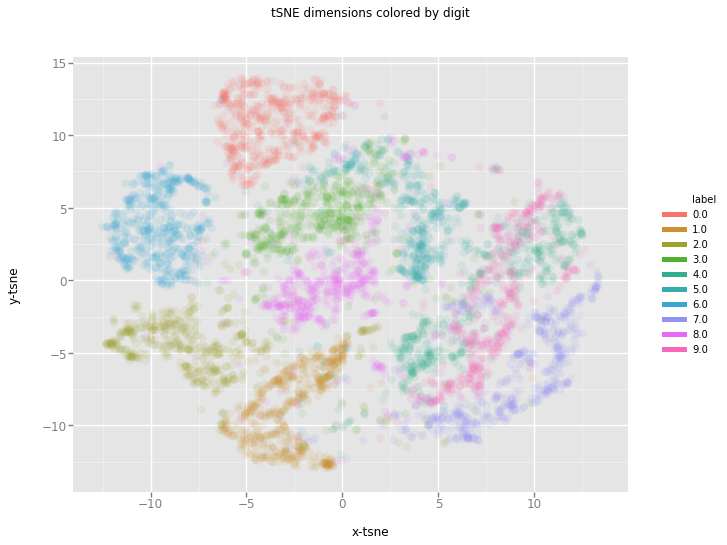

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.716s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.024892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.145050
[t-SNE] Error after 300 iterations: 1.854928
(65000, 10)
(65000, 1)
t-SNE done! Time elapsed: 53.99614357948303 seconds


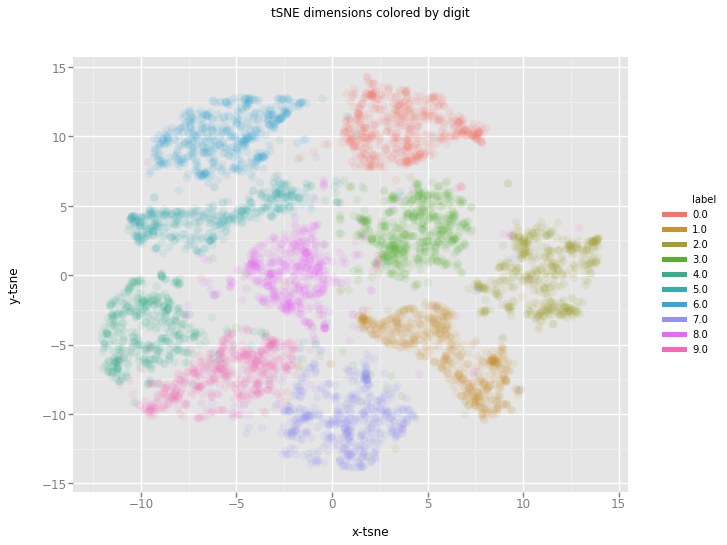

In [42]:
import time
from sklearn.manifold import TSNE
from ggplot import *

def tsne(x,y,n_sne):  
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(x[:n_sne])
    print(x.shape)
    print(y.shape)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    x_tsne = np.expand_dims(tsne_results[:,0],1)
    y_tsne = np.expand_dims(tsne_results[:,1],1)
    label = np.int32(y[:n_sne])
    data = np.concatenate((x_tsne,y_tsne,label),axis=1)

    df_tsne = pd.DataFrame(data=data,columns=['x-tsne','y-tsne','label'])
    df_tsne.label  = df_tsne.label.map(lambda x:  str(x))
    chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
            + geom_point(size=70,alpha=0.1) \
            + ggtitle("tSNE dimensions colored by digit")
    chart.show()
tsne(X_train,y_train,5000)
tsne(sae.extract_feature,y_train,5000)